Slideshow about this project. install RISE by damianavila from https://github.com/damianavila/RISE to use jupyter notebook as slideshow

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import product
%matplotlib inline

from keras.models import load_model
import keras

from utils import data_utils as du
from utils import preprocessing_utils as pu
from unet import unet_builder
import seaborn as sns
import pickle
from IPython.display import IFrame


Using TensorFlow backend.


In [2]:
from rasterio import logging

log = logging.getLogger()
log.setLevel(logging.ERROR)
np.set_printoptions(suppress=True)

plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.4

## Maanpeiteluokittelu syväoppimismenetelmillä
### Janne Mäyrä
### 12.12.2018

## Sisältö
---
* Syväoppiminen hyvin lyhyesti
* Case Kaakonkulma

## Syväoppiminen? Koneoppiminen? AI?
---

<center>
<img src="presentation_images/machine_learning.png">
</center>


## Vakavammin sanottuna
---
<center>
<img src="presentation_images/ai_ml_dl.png">
</center>


## Syväoppiminen ja neuroverkot (ANN)
---
* Lineaarinen luokittelu ja regressio *y = Wx + b*

* Syväoppimisessa näitä luokittelijoita yhdistellään aktivaatiofunktioilla toisiinsa
  * Yksikerroksinen neuroverkko *y = W<sub>2</sub> max(0, W<sub>1</sub>x) + b*
  * Kaksikerroksinen neuroverkko *y = W<sub>3</sub> max(W<sub>2</sub> max(0, W<sub>1</sub>x))*
  * Aktivaatiofunktiona yllä max(x, 0) eli ReLU (Rectified Linear Unit)

* Syvissä neuroverkoissa voi olla kymmeniä tai jopa satoja kerroksia, ja kerroksissa vastaavasti kymmeniä(tai satoja) neuroneja

## Kaksikerroksinen neuroverkko
---
<center><img src='presentation_images/neural_net2.jpeg'></center>

## Konvoluutio
---

In [3]:
IFrame('http://cs231n.github.io/assets/conv-demo/index.html', width=800, height=700)

## CNN eli konvoluutioneuroverkko
---
* Erityisesti kuvien mutta myös esimerkiksi luonnollisten kielten prosessointiin käytetty neuroverkkotyyppi

* Vähintään yhdessä kerroksessa matriisitulo on korvattu konvoluutiolla

* Konvoluution ansiosta painokertoimia tarvitsee laskea **paljon** vähemmän 
  * 100x100px mustavalkokuvan luokittelua varten ANN:n toisen kerroksen yhdessä neuronissa on 10000 painokerrointa
  * CNN:n vastaavassa kernelissä on yleensä 288 painokerrointa

## Verkkojen kouluttaminen 
---
* Käytännössä matemaattista optimointia
  1. Luokitellaan jonkin verran koulutusaineistoa
  2. Lasketaan tappiofunktion (loss function) arvo
  3. Lasketaan gradientti verkon yli
  4. Hienosäädetään painokertoimia negatiivisen gradientin suuntaan
  5. Palaa kohtaan 1

* ...eli käytännössä kirjoitetaan model.fit(\*\*parametrit) ja odotellaan

## Case Kaakonkulma
---
* Workflow
* Aineisto tarkemmin
* Neuroverkko
* Luokittelu

## Workflow
---

* Aineiston tutkiminen, korjaaminen ja esikäsittely
  * Työaikaa vievin homma

* Verkon kouluttaminen
  * Vie aikaa, muttei työaikaa

* Luokittelujen analysointi
  * Confusion matrix, kartalta tutkiminen, precision/recall/accuracy ja muut metriikat

## Aineisto
---
* "Ground truth" Corine Land Cover 2018 luokittelun pohjalta muodostetut luokat
  * 13 luokkaa
  * **Todella** epätasapainossa olevat luokat
* Pilvetön Corine-mosaiikki kesältä 2017
  * 9-kanavainen monispektrikuva (RGB, Red-Edge, Nir, SWIR)
* Viisi spektri-indeksiä
  * NDVI, NDTI, NDBI, NDMI, NDSI
* Spatiaalinen resoluutio 10x10m

## Aineiston esikäsittely
---

* Puuttuvan tai virheellisen lähtödatan korjaaminen
  * Corine-mosaiikin osalta paikattu kevätmosaiikin paloilla
  * Spektri-indeksejä ei koko alueelta -> cropataan 500 pikseliä joka reunalta pois
  * Mahdolliset puuttuvat maanpeiteluokat korvattu mediaanilla

* Koulutus ja validointiaineistojen valinta
  * 10 850x850px kuvaa suhteellisen mielivaltaisesti valittuna 
  * 8 kuvaa koulutusaineistoksi, 2 kuvaa validointia varten. Testiaineistoksi koko kuva.

* Aineisto normalisoitu koulutusaineiston perusteella

## CNN ja sen kouluttaminen
---

* Pohjana U-Net, joka on käytännössä de-facto standardi tämänkaltaisissa tehtävissä

<center><img src="presentation_images/u-net-architecture.png" width="60%" height="50%"></center>

## CNN ja sen kouluttaminen
---
* Vaikka aineistona on nyt vain 8 kuvaa, käytännössä siitä saadaan loputtomasti koulutusdataa
  * Jokainen minibatch käsittää 8 pienempää kuvaa, jota on augmentoitu seuraavasti:
     * Valitaan satunnaisesti yksi em. kuvista
     * Leikataan siitä 8 64x64, 128x128, 256x256 tai 384x384px kuvaa
     * Jokaista em. kuvaa augmentoidaan satunnaisesti kiertämällä ja heijastamalla
* Jokainen aika-askel käsittää 500 tällaista minibatchia, jonka jälkeen validointi 100 minibatchilla

## CNN ja sen kouluttaminen
---
* Kouluttaminen totetutettu CSC:n taito-gpu -laskentaklusterissa
  * Syy: tehokas näytönohjain **täysin välttämätön** tämäntyylisen verkon kouluttamiseen
* Yksi aika-askel P100-GPGPUlla kestää noin 5 minuuttia -> 100 aika-askelta kestää noin 8,5h


## Luokittelu ja analysointi
---
* Luokittelu on varsin kevyt toimenpide verrattuna kouluttamiseen

In [4]:
ground_truth = '../input_marras2018/lopulliset_tavoiteluokat.nc'
test_bands = '../input_marras2018/patched_summer_2017.nc'
test_indices = '../input_marras2018/kaakonkulma_s2ind_20170601_20170831_rp.img'
bands = xr.open_rasterio(test_bands)
indices = xr.open_rasterio(test_indices)

vals = np.vstack((bands.values, indices.values))
vals = vals[:,500:-501, 500:-500]
vals = vals.astype('float32')
with open('train_means.obj', 'rb') as t:
    train_means, train_std = pickle.load(t)
for i in range(14):
    vals[i] = (vals[i] - train_means[i]) / (train_std[i] + 1e-8)
    
import math
chans = 14
width = 256
height = 256
class_band = 0
x_start = 0
y_start = 0

x_pad = (math.ceil(vals.shape[2] / width) * width - vals.shape[2])//2
y_pad = (math.ceil(vals.shape[1] / height) * height - vals.shape[1])//2
padded_vals = np.pad(vals, ((0,0), (y_pad, y_pad), (x_pad, x_pad)), 'reflect')
x_end = padded_vals.shape[2]
y_end = padded_vals.shape[1]
steps = ((x_end - x_start) // width) * ((y_end - y_start) // height)

C:\Users\E1005164\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


In [17]:
unet =  unet_builder.build_unet(14,13, activation='softmax')
unet.load_weights('models/98-1.20.h5')
pred = unet.predict_generator(du.sub_image_generator(padded_vals, 0, padded_vals.shape[2], width, 
                                                        0, padded_vals.shape[1], height, chans), 
                                                        steps=steps, workers=1, max_queue_size=40, verbose=1)

528/528 [==============================] - 790s 1s/step


In [6]:
full_image = du.create_full_image(np.argmax(pred, axis=-1), x_start, x_end, y_start, y_end)
unpadded_image = full_image[x_pad:-x_pad, y_pad:-y_pad]

def untile_preds(preds, x_start, x_end, y_start, y_end):
    row_len = x_end - x_start
    col_len = y_end  - y_start
    
    n, nrows, ncols, dim = preds.shape
    return (preds.reshape(row_len//nrows, -1, nrows, ncols, dim)
            .swapaxes(1,2).reshape(row_len, col_len, dim))

full_preds = untile_preds(pred, x_start, x_end, y_start, y_end)[x_pad:-x_pad, y_pad:-y_pad,...].swapaxes(0,1)

truth = xr.open_dataarray(ground_truth)
truth_cust = truth[0, 500:-501, 500:-500].values
truth_cust[~np.isnan(truth_cust)] -= 1

unpadded_image = unpadded_image.T
unpadded_image = unpadded_image.astype('float32')

from sklearn.metrics import classification_report

labels = ['Built-up areas, sparse',
          'Built-up areas, dense',
          'Bare areas',
          'Grasslands',
          'Fields',
          'Broad-leaved forest',
          'Pine-dominated coniferous forest',
          'Spruce-dominated coniferous forest',                       
          'Mixed forest',
          'Transitional woodland shrub',
          'Inland marshes',
          'Water vegetation',
          'Water bodies']

## Tähän väliin summary käytetystä verkosta
---

In [7]:
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
encoder_stage0_conv1 (Conv2D)   (None, None, None, 3 4032        input_1[0][0]                    
__________________________________________________________________________________________________
encoder_stage0_bn1 (BatchNormal (None, None, None, 3 128         encoder_stage0_conv1[0][0]       
__________________________________________________________________________________________________
encoder_stage0_relu1 (Activatio (None, None, None, 3 0           encoder_stage0_bn1[0][0]         
__________________________________________________________________________________________________
encoder_st

## Luokittelutarkkuus verrattuna CLC2018 luokkiin
---

In [18]:
print(classification_report(truth_cust[~np.isnan(truth_cust)].ravel(), unpadded_image[~np.isnan(truth_cust)].ravel(), 
                            target_names = labels))

                                    precision    recall  f1-score   support

            Built-up areas, sparse       0.55      0.67      0.61    744948
             Built-up areas, dense       0.58      0.51      0.54    470616
                        Bare areas       0.65      0.48      0.55    279716
                        Grasslands       0.43      0.06      0.10    245548
                            Fields       0.86      0.83      0.84   2319752
               Broad-leaved forest       0.51      0.30      0.38    535588
  Pine-dominated coniferous forest       0.63      0.75      0.68   5684239
Spruce-dominated coniferous forest       0.55      0.62      0.58   2301589
                      Mixed forest       0.54      0.50      0.52   2714796
       Transitional woodland shrub       0.68      0.43      0.52   2058796
                    Inland marshes       0.68      0.44      0.53    125516
                  Water vegetation       0.63      0.45      0.53    142516
           

In [9]:
from matplotlib.colors import ListedColormap

def show_classifications(x_start, x_end, y_start, y_end, preds, truth, labels):

    f, (ax1, ax3, ax4) = plt.subplots(ncols=3,figsize=(16,8), 
                                     gridspec_kw={"width_ratios":[1,1, 0.05]})

    plt.setp([ax1, ax3], xticks=[], xticklabels=["27°55'E","28°50'E"],
            yticks=[], yticklabels=["61°15'N","60°39'N"])

    ax4.set_xticks([])
    ax4.set_yticks([])


    colormap = ListedColormap(plt.cm.tab20(np.linspace(1,0,len(labels))))

    ax1.set_title('CLC 2018 classes')
    im1 = ax1.imshow(truth[y_start:y_end, x_start:x_end], vmin=0, vmax=len(labels)-1, cmap=colormap)
    ax3.set_title('Predicted classes')
    im2 = ax3.imshow(preds[y_start:y_end, x_start:x_end], vmin=0, vmax=len(labels)-1, cmap=colormap)

    cbar = f.colorbar(im1, cax=ax4, ticks=range(0,len(labels), 1))
    cbar.set_ticklabels(labels)
    plt.show()

## Visuaalinen vertailu
---

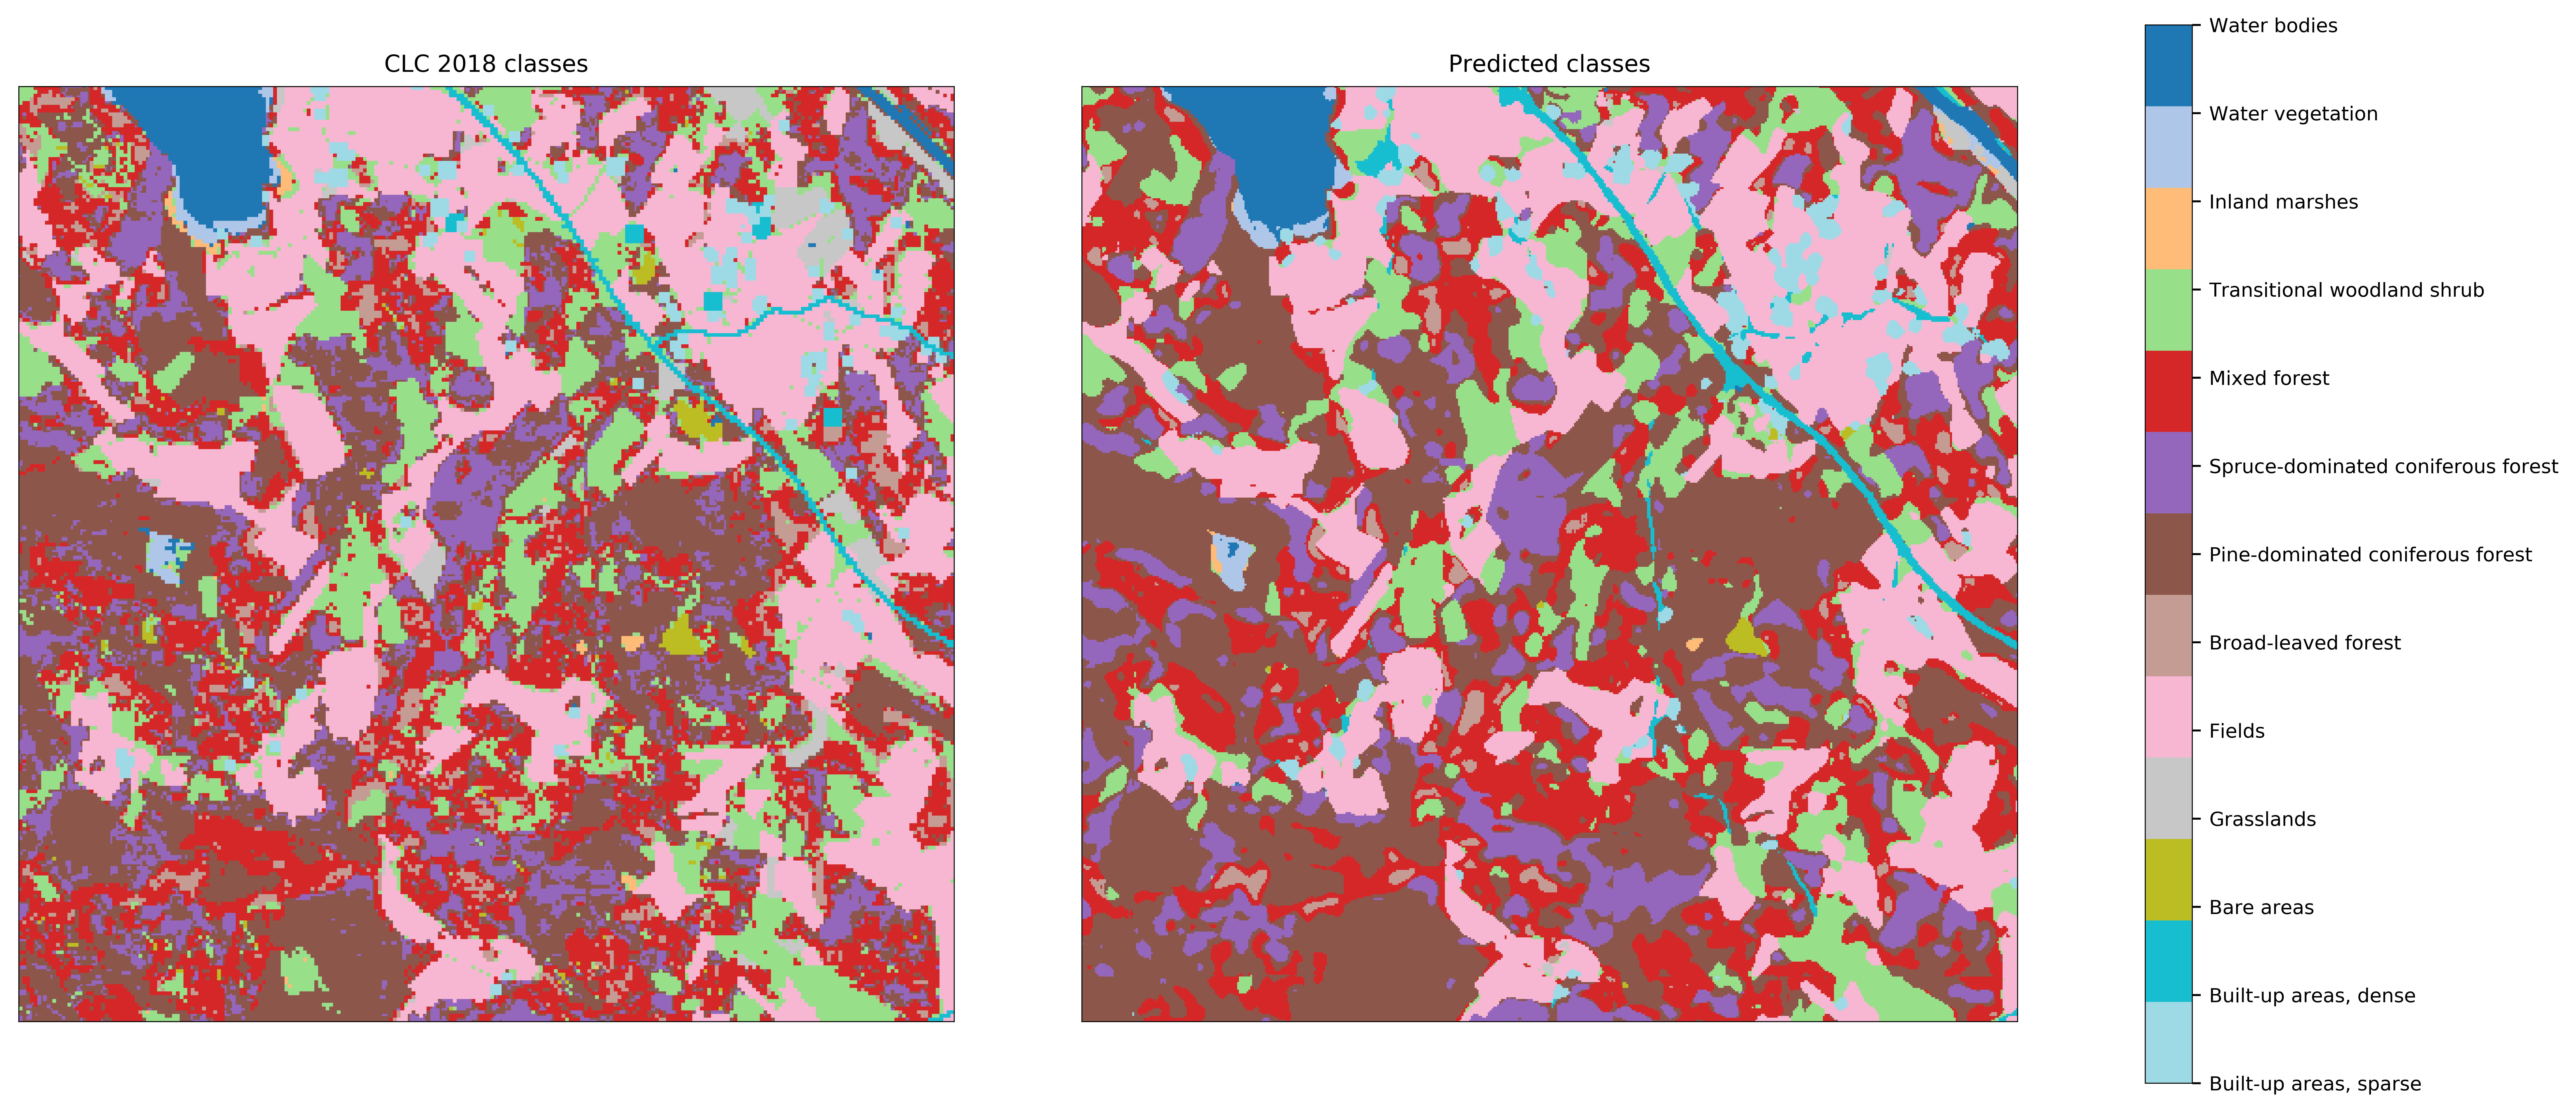

In [21]:
show_classifications(2750,3250,1750,2250, unpadded_image, truth_cust, labels)

## Sovelluksia tälle nimenomaiselle verkolle
---
* Ravinnekuormien laskeminen maanpeiteluokkien pohjalta
* Maanpeitemuutosten laskeminen satelliittikuvien ja indeksikuvien pohjalta
* Peltolohkojen luokittelu ja vilja-sadon arviointi

## Jatkokehitys
---
* Verkkojen kouluttaminen laajemalla aineistolla
  * Aineisto joko aitoa tai synteettistä, esimerkiksi GAN-verkoilla luotua
    * GAN eli Generative Adversarial Network, yksinkertaistettuna kaksi verkkoa joista toinen luo aineistoa ja toinen pyrkii tunnistamaan onko kyseessä aito kuva
* Hyperparametrien hienosäätö
  * Hyperparametri eli muuttuja, joka ei muutu koulutuksen aikana
    * Esimerkiksi optimointialgoritmi, loss function, regularisoinnit...